# Setup


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/UFCG/CDP/ClassificaçãoClientes/client_segment_classification_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UFCG/CDP/ClassificaçãoClientes/client_segment_classification_test.csv')

# Análise Exploratória dos Dados

In [ ]:
X_train = train_df.drop('Segmentation', axis=1)
y_train = train_df['Segmentation']

In [ ]:
X_test = test_df.drop('Segmentation', axis=1)
y_test = test_df['Segmentation']

In [ ]:
num_cols = ['Age', 'Work_Experience', 'Family_Size']
cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [ ]:
# Treinar o modelo
model_pipeline.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model_pipeline.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.4f}')

Acurácia do modelo: 0.3057


# Análise Exploratória de Dados para Classificação de Segmentos de Clientes

## Tratamento de Dados Ausentes
Observei a exsitência de alguns dados ausentes em várias colunas, algumas delas foram  'Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size' e 'Var_1'. A abordagem que adotei para resolver essa situação foi o preenchimento para dados categóricos com valor mais frequente e, para dados numéricos, utilização da mediana.
## Variáveis Categóricas
Tratei as variáveis categóricas através da cotificação one-hot, permitindo a utilização dessas variáveis nos modelos preditivos.
## Distribuição da Variável-Alvo
A distribuição da variável-alvo 'Segmentation' mostrou-se relativamente balanceada entre as quatro classes, o que é positivo para contrução de um modelo de classificação equilibrado.
## Conclusão da Análise Exploratória
A análise exploratória inicial dos dados revelou informações cruciais para o desenvolvimento de modelos preditivos efecazes. Identifiquei a ausência de dados em várias colunas importantes.
A distribuição balanceada da nossa variável-alvo, Segmentation, sugere que temos uma boa base para o desenvolvimento de um modelo que pode classificar de forma equitativa os clientes nos segmentos 'A', 'B', 'C' e 'D'. Este é um ponto forte dos nossos dados, pois desequilíbrios significativos poderiam levar a modelos com viéses para as classes mais frequentes.
A acurária de 30,57% serve como um ponto de partida para iterações futuras no desenvolvimento do modelo.

# Treinamento e Fine-tuning do Modelo de Regressão Logística

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)

In [ ]:
grid_search.fit(X_train_preprocessed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'lbfgs']},
             scoring=make_scorer(f1_score, average=weighted))

In [ ]:
best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict(X_test_preprocessed)

In [ ]:
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

In [ ]:
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor F1 Score ponderado no conjunto de treino (via CV): {grid_search.best_score_:.4f}")
print(f"F1 Score ponderado no conjunto de teste: {f1:.4f}")

Melhores hiperparâmetros: {'C': 0.1, 'solver': 'lbfgs'}
Melhor F1 Score ponderado no conjunto de treino (via CV): 0.4944
F1 Score ponderado no conjunto de teste: 0.3276


## Justificativa
*   Métrica 'f1_score' ponderado: Escolhi essa métrica devido sua capacidade de equilibrar a precisão e o recall em um cenário de múltiplas classes, oferencendo uma medida robusta do desempenho geral do modelo, especialmetne em conjuntos de dados com distribuição desigual de classes.
*   Hiperparâmetros 'C' e 'solver': A regularização 'C' ajuda a evitar overfitting ajustando a complexidade do modelo, enquanto 'solver' é o algoritmo usado para otimização. Diferentes solvers podemter desempenhos variados dependendo do tamanho e da natureza dos dados.



# Treinamento e Fine-tuning do Modelo de Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
model_nb = GaussianNB()

In [ ]:
model_nb.fit(X_train_preprocessed, y_train)

GaussianNB()

In [ ]:
y_pred_nb = model_nb.predict(X_test_preprocessed)

In [ ]:
f1_test = f1_score(y_test, y_pred_nb, average='weighted')
print(f"F1 Score ponderado no conjunto de teste: {f1_test:.4f}")

F1 Score ponderado no conjunto de teste: 0.3084


## Justificativa
*   Para o fine-tuning e avaliação do modelo Naive Bayes, escolhi novamente o 'f1_score' ponderado como métrica devido à sua capacidade de equilibrar precisão e recall, o que nos oferece uma visão holística do desempenho do modelo em um contexto multiclasse.



#Treinamento e Fine-Tuning do Modelo de Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

In [ ]:
model_dt = DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20]
}

In [ ]:
scorer = make_scorer(f1_score, average='weighted')

In [ ]:
grid_search_dt = GridSearchCV(model_dt, param_grid, scoring=scorer, cv=5, verbose=1)

grid_search_dt.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [ ]:
best_model_dt = grid_search_dt.best_estimator_

In [ ]:
y_pred_dt = best_model_dt.predict(X_test_preprocessed)

In [ ]:
f1_test_score = f1_score(y_test, y_pred_dt, average='weighted')
print(f"Melhores hiperparâmetros: {grid_search_dt.best_params_}")
print(f"Melhor F1 Score ponderado (treino): {grid_search_dt.best_score_:.4f}")
print(f"F1 Score ponderado (teste): {f1_test_score:.4f}")

Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_split': 20}
Melhor F1 Score ponderado (treino): 0.5015
F1 Score ponderado (teste): 0.3181


## Justificativa
*   Mantive o 'f1_score' ponderado como métrica de avaliação e fine-tuning, pois leva em conta tanto a precisão quanto o recall, o que proporciona uma visão equilibrada do desempenho do modelo.
*   Foram ajustados parâmetros como a profundidade máxima da árvore ('max_depth') e o número mínimo de amostras nescessárias para dividir um nó interno ('min_samples_slit'). Utilizei o "GridSearchCV' para explorar combinações desses hiperparâmetros e encontrar a melhor configuração com base no 'f1_score' ponderado.





# Treinamento e Fine-Tuning do Modelo RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

In [ ]:
model_rf = RandomForestClassifier(random_state=42)

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
scorer_rf = make_scorer(f1_score, average='weighted')

In [ ]:
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, scoring=scorer_rf, cv=5, verbose=1)

grid_search_rf.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [ ]:
best_model_rf = grid_search_rf.best_estimator_

In [ ]:
y_pred_rf = best_model_rf.predict(X_test_preprocessed)

In [ ]:
f1_test_score_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Melhores hiperparâmetros: {grid_search_rf.best_params_}")
print(f"Melhor F1 Score ponderado (treino): {grid_search_rf.best_score_:.4f}")
print(f"F1 Score ponderado (teste): {f1_test_score_rf:.4f}")

Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Melhor F1 Score ponderado (treino): 0.5295
F1 Score ponderado (teste): 0.3356


## Justificativa
*   O RandomForest é um modelo poderoso, capaz de lidar com a complexidade de dados multiclasse devido à sua natureza de agragação de múltiplas árvores de decisão, reduzindo o risco de overfitting presente em modelo de árvores de decisão única. O fine-tuning dos hiperparâmetros, especialmente 'n_estimators', 'max_depth' e 'min_samples_split', é crucial para garantir que o modelo seja capaz de aprender padrões nos dados sem se tornar excessivamente complexo.
*   A métrica selecionada se mantém a 'f1_score' ponderado, devido sua capacidade de fornecer uma visão balanceada do desempenho do modelo em situações com classes desbalanceadas, combinando precisão e recall de uma maneira que leva em conta a importância de cada classe baseada em sua frequência.
*   Para o RadomForest, hiperparâmetros como o número de árvores na floresta ('n_estimators'), a profundidade máxima das árvores ('max_depth'), e o número mínimo de amostras nescessárias para dividir um nó interno ('min_samples_split') foram considerados no processo de fine-tuning. Utilizei 'GridSearchCV' para encontrar a melhor combinação desses hiperparâmetros com base no 'f1_score' ponderado





# Avaliação

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
models_predictions = {
    "Regressão Logística": y_pred_logreg,
    "Naive Bayes": y_pred_nb,
    "Árvore de Decisão": y_pred_dt,
    "RandomForest": y_pred_rf
}

In [ ]:
for model_name, y_pred in models_predictions.items():
    print(f"Modelo: {model_name}")
    print(f"Precision (weighted): {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}\n")

Modelo: Regressão Logística
Precision (weighted): 0.3327
Recall (weighted): 0.3331
Acurácia: 0.3331
F1-Score (macro): 0.3126
F1-Score (weighted): 0.3276

Modelo: Naive Bayes
Precision (weighted): 0.3274
Recall (weighted): 0.3167
Acurácia: 0.3167
F1-Score (macro): 0.3009
F1-Score (weighted): 0.3084

Modelo: Árvore de Decisão
Precision (weighted): 0.3232
Recall (weighted): 0.3182
Acurácia: 0.3182
F1-Score (macro): 0.3086
F1-Score (weighted): 0.3181

Modelo: RandomForest
Precision (weighted): 0.3390
Recall (weighted): 0.3369
Acurácia: 0.3369
F1-Score (macro): 0.3258
F1-Score (weighted): 0.3356



## Análise Comparativa

*   RandomForest: mostrou o melhor desempenho em quase todas as métricas, com a maior Precicion ponderada (0.3390), Recall ponderado (0.3369), Acurácia (0.3369), e F1-Score ponderado (0.3356). Isso indica que o modelo foi o mais eficaz em generalizar para o conjunto de teste, oferencendo um equilíbrio razoável entre a capacidade de detectar a classe positiva (Precision) e a sensibilidade para capturar a maioria dos casos positivos reais (Recall).
*   Regressão Logistica: Apresenta os resultados ligeiramente menores que RandomForest, mas ainda assim relativamente equilibrado em termos de Precision ponderada (0.3327) e Recall ponderado (0.3331), com uma Acurácia similar (0.3331). O F1-Score ponderado (0.3276) está um pouco abaixo do RandomForest, sugerindo que, embora seja um modelo robusto, talvez não capture tão efetivamente a complexidade dos dados quanto o RandomForest.
*   Naive Bayes e Árvore de Decisão: apresentaram os menores valores em todas as métricas, com o Naive Bayes mostrando ligeiramente menos eficácia do que a Árvore de Decisão em termos de Precision ponderada, Recall ponderado, e Acurácia. Isso pode ser devido à simplificação inerente da suposição de independência entre os atributos que o Naive Bayes faz, o que nem sempre se aplica a conjunto de dados complexos.

## Satisfação com os Resultados
Os resultados obtidos não são considerados altamente satisfatórios, visto que todas as métricas estão abaixo de 0.4 para todos os modelos, o que indica um desempenho moderado. Isso sugere que há uma margem significativa para melhoria, podendo ser a inclusão de mais dados ou a exploração de modelos mais complexos e técnicas avançadas de machine learning.

## O Melhor Modelo
A partir das métricas obtidas, o modelo RandomForest é o melhor modelo entre os avaliados, demonstrando a maior eficácia geral em equilibrar a precisão e a capacidade de recall, além de alcançar o F1-Score ponderado mais alto. Isso sugere que a agragação de múltiplas árvores de decisão para formar a "floresta" ajuda a modelar a complexidade dos dados mais efetivamente do que os modelos mais simples.

# Plote da Árvore de Decisão

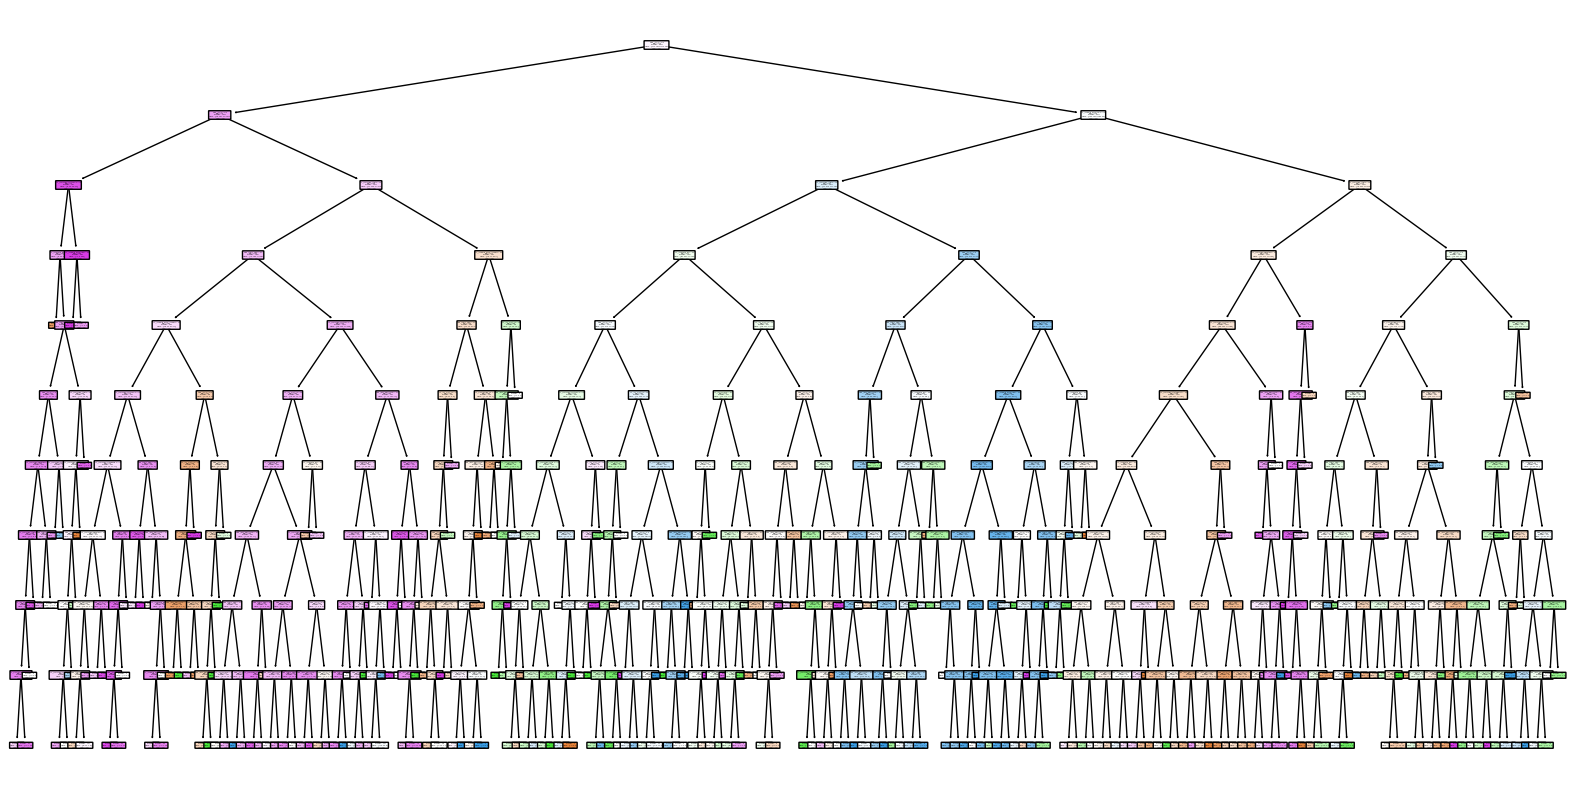

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_model_dt, filled=True, feature_names=preprocessor.get_feature_names_out(), class_names=True, rounded=True, proportion=False, precision=2)
plt.show()

## Simplificando o modelo

In [ ]:
simple_dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
simple_dt_model.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

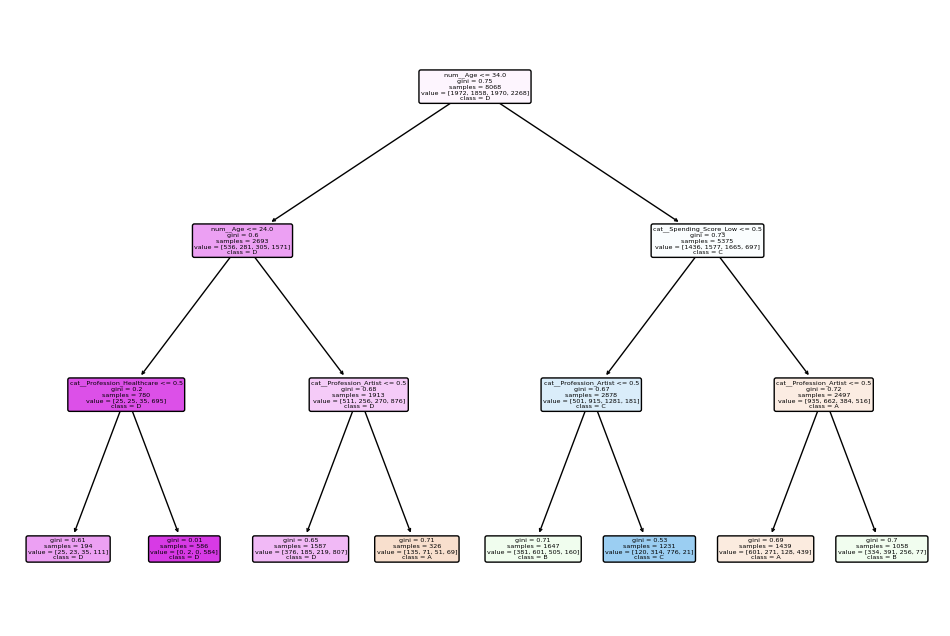

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(simple_dt_model, filled=True, feature_names=preprocessor.get_feature_names_out(), class_names=['A', 'B', 'C', 'D'], rounded=True, proportion=False, precision=2)
plt.show()

## Análise da Árvore de Decisão Simplificada

### Nó Raiz (num_Age <= 34.0):
-A decisão inicial da árvore é baseada na idade. Os clientes com 34 anos ou menos são separados daquelas com mais de 34 anos. Isso sugere que a idade é uma variável importante no que diz respeito à segmentação dos clientes, possivelmente devido a padrões de comportamento ou preferências de consumo que variam significativamente com a idade.
### Primeira Ramificação (Esquerda para Idades <= 34, Direita para Idades > 34):
-Esquerda: Os clientes mais jovens são então avaliados com base em seu status de 'Ever_Married', o que implica que, para os clientes mais jovens, o estado civil desempenham um papel significativo na segmentação. Isso pode estar relacionado a fatores como renda disponível, estágio de vida ou prioridades de consumo.
Direita: Entre os cliente mais velhor, o modelo avalia a 'Spending_Score' para realizar a próxima divisão, indicando que, para esse grupo etário, a disposição para gastar é um discriminante importante na determinação de segmentos de mercado.
### Segunda Ramificação e Nós Folha:
Após as primeiras decisões, a árvore faz mais algumas divisões com base em profissões específicas ('Healthcare', 'Artist'), que mostra a relevância das profissões nos padrões de segmentação dos clientes.
As folhas finais (nós terminais) da árvore simplificada representam as classes de segmentação preditas pelo modelo. Cada folha mostra a classe majoritária para clientes que seguem as decisões ao longo da árvore.

### Conclusão:
A árvore simplicada fornece uma interpretação clara e gerenciável do modelo. A idade aparece como um fator importante, e as divisões subsequentes se baseiam em combinações de esptado civil e pontuação de gastos, com considerações de carreira também desempenhando um papel. Essa interpretação pode ser útil para desenvolver estratégias de marketing direcionadas e entender melhor as necessidades e preferências dos diferentes segmentos de clientes.
Embora uma árvore completa possa capturar mais nuances e possa ter um desempenho preditivo superior, a árvore simplificada oferece um equilíbrio entre interpretabilidade e desempenho, o que pode ser particularmente valioso em situações onde a explicabilidade é crucial.